# Modeling spawning salmon

The plot below shows the relationship between the number of spawning salmon in a particular stream and the number of fry that are recruited into the population in the spring.

We would like to model this relationship, which appears to be non-linear (we have biological knowledge that suggests it should be non-linear too).

![](images/spawn.jpg)

In [14]:
import os

os.environ['MKL_NUM_THREADS'] = '1'
os.environ['OPENBLAS_NUM_THREADS'] = '1'

In [15]:
%matplotlib inline
import numpy as np
import pandas as pd
import pymc3 as pm
import arviz as az
import matplotlib.pyplot as plt

import warnings
warnings.simplefilter('ignore')

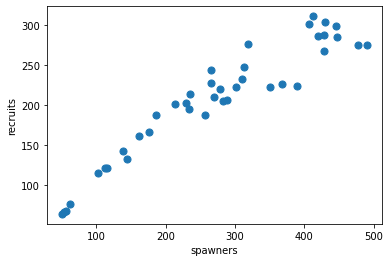

In [16]:
salmon_data = pd.read_table('../data/salmon.txt', sep='\s+', index_col=0)
salmon_data.plot.scatter(x='spawners', y='recruits', s=50);

# Parametric approaches

Simple linear regression:

$$ y_i = \beta_0 + \beta_1 x_i + \epsilon_i $$

$$ \epsilon_i \sim N(0, \sigma) $$

There are three unknowns, each of which need to be given a prior:

$$\beta_0, \beta_1 \sim \text{Normal}(0, 50)$$

$$\sigma \sim \text{HalfNormal}(50)$$

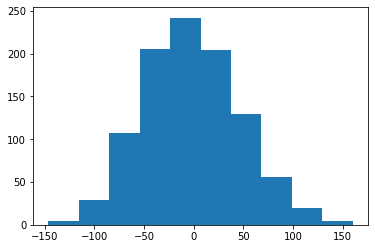

In [17]:
a_normal_distribution = pm.Normal.dist(mu=0, sigma=50)
plt.hist(a_normal_distribution.random(size=1000));

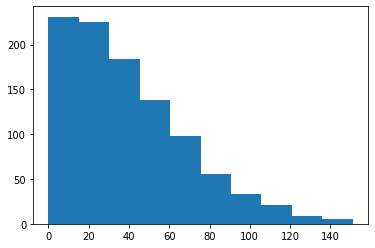

In [18]:
a_half_normal_distribution = pm.HalfNormal.dist(sigma=50)
plt.hist(a_half_normal_distribution.random(size=1000));

Extract our predictor and response variables.

In [19]:
x, y = salmon_data[['spawners', 'recruits']].values.T

Construct a model in PyMC3.

In [20]:
with pm.Model() as linear_salmon_model:
    
    β0 = pm.Normal('β0', mu=0, sigma=50)
    β1 = pm.Normal('β1', mu=0, sigma=50)
    σ = pm.HalfNormal('σ', sigma=50)
    
    μ = β0 + β1 * x
    
    recruits = pm.Normal('recruits', mu=μ, sigma=σ, observed=y)

Fit the model using Markov chain Monte Carlo (MCMC).

In [21]:
with linear_salmon_model:
    
    linear_trace = pm.sample(1000, tune=2000, cores=4)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [σ, β1, β0]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 18 seconds.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6551265034927691, but should be close to 0.8. Try to increase the number of tuning steps.


Examine the posterior distributions of the unknown parameters.

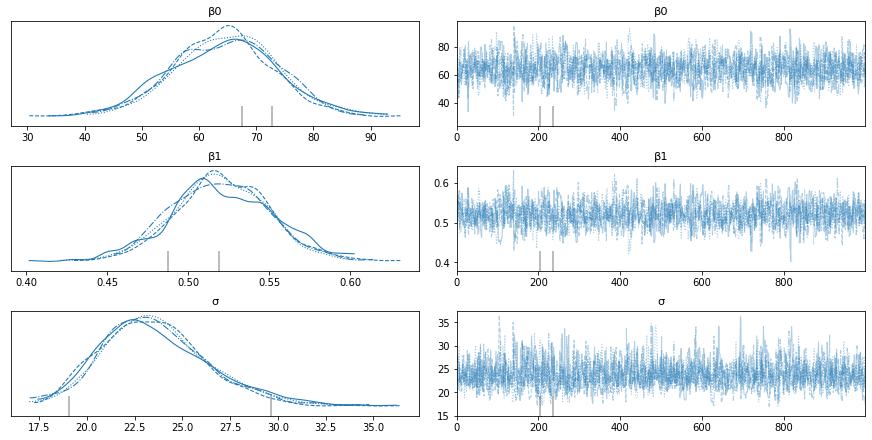

In [22]:
az.plot_trace(linear_trace);

Draw posterior samples of the regression line.

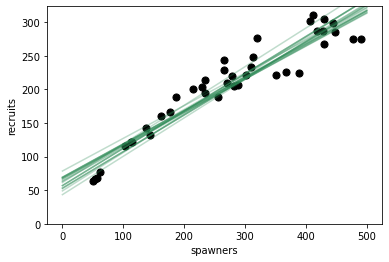

In [23]:
X_pred = np.linspace(0, 500, 100)

ax = salmon_data.plot.scatter(x='spawners', y='recruits', c='k', s=50)
ax.set_ylim(0, None)
for b0,b1 in zip(linear_trace['β0'][:20], linear_trace['β1'][:20]):
    ax.plot(X_pred, b0 + b1*X_pred, alpha=0.3, color='seagreen');

### Quadratic Model

It appears the linear model is a poor fit to the data. Let's make a polynomial (quadratic) model by adding a parameter for $x^2$.

In [24]:
with pm.Model() as quad_salmon_model:
    
    β = pm.Normal('β', mu=0, sigma=50, shape=3)
    σ = pm.HalfNormal('σ', sigma=50)
    
    μ = β[0] + β[1] * x + β[2] * x**2
    
    recruits = pm.Normal('recruits', mu=μ, sigma=σ, observed=y)

In [25]:
with quad_salmon_model:
    
    quad_trace = pm.sample(1000, tune=2000, cores=2, random_seed=1)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [σ, β]


Sampling 2 chains for 2_000 tune and 1_000 draw iterations (4_000 + 2_000 draws total) took 23 seconds.
There were 33 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7189844565602667, but should be close to 0.8. Try to increase the number of tuning steps.
There were 8 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


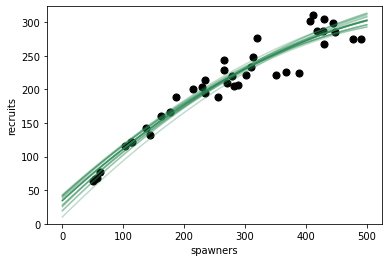

In [26]:
ax = salmon_data.plot.scatter(x='spawners', y='recruits', c='k', s=50)
ax.set_ylim(0, None)
for b0,b1,b2 in quad_trace['β'][:20]:
    ax.plot(X_pred, b0 + b1*X_pred + b2*X_pred**2, alpha=0.3, color='seagreen');

![](images/stop.jpg)

Let's go back to the slides ...

---

## Gaussian Process

In [27]:
with pm.Model() as gp_salmon_model:

    # Lengthscale
    ρ = pm.HalfCauchy('ρ', 5)
    η = pm.HalfCauchy('η', 5)
    
    M = pm.gp.mean.Linear(coeffs=(salmon_data.recruits/salmon_data.spawners).mean())
    K = (η**2) * pm.gp.cov.ExpQuad(1, ρ) 
    
    σ = pm.HalfNormal('σ', 50)
    
    recruit_gp = pm.gp.Marginal(mean_func=M, cov_func=K)
    recruit_gp.marginal_likelihood('recruits', X=salmon_data.spawners.values.reshape(-1,1), 
                           y=salmon_data.recruits.values, noise=σ)
    

In [28]:
with gp_salmon_model:
    gp_trace = pm.sample(1000, tune=2000, cores=2, random_seed=42)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [σ, η, ρ]


Sampling 2 chains for 2_000 tune and 1_000 draw iterations (4_000 + 2_000 draws total) took 25 seconds.
The number of effective samples is smaller than 25% for some parameters.


In [29]:
with gp_salmon_model:
    fit = pm.find_MAP()
fit

{'ρ_log__': array(-6.34231557),
 'η_log__': array(-5.71979021),
 'σ_log__': array(3.96209171),
 'ρ': array(0.00176022),
 'η': array(0.0032804),
 'σ': array(52.56716654)}

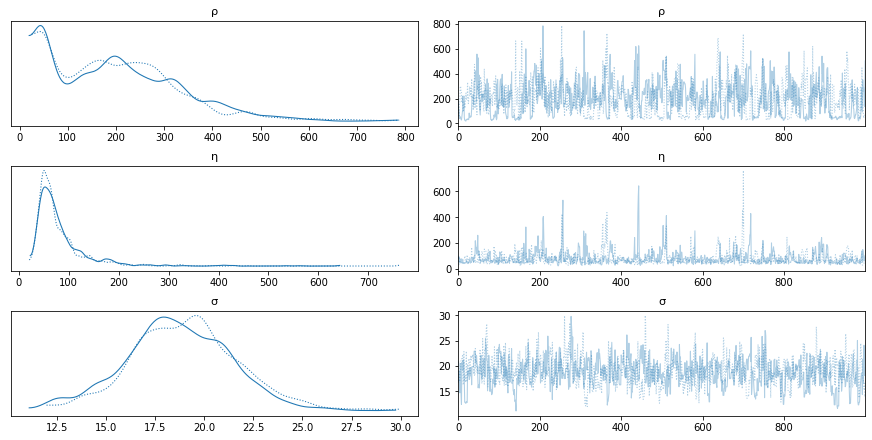

In [30]:
az.plot_trace(gp_trace, var_names=['ρ', 'η', 'σ']);

In [31]:
with gp_salmon_model:
    salmon_pred = recruit_gp.conditional("salmon_pred", X_pred.reshape(-1, 1))
    gp_salmon_samples = pm.sample_posterior_predictive(gp_trace, var_names=["salmon_pred"], samples=3, random_seed=42)

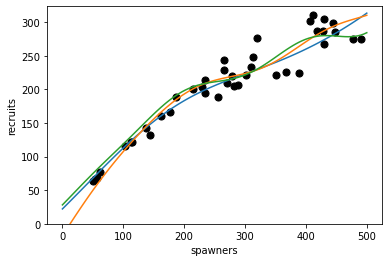

In [32]:
ax = salmon_data.plot.scatter(x='spawners', y='recruits', c='k', s=50)
ax.set_ylim(0, None)
for x in gp_salmon_samples['salmon_pred']:
    ax.plot(X_pred, x);

In [33]:
with gp_salmon_model:
    gp_salmon_samples = pm.sample_posterior_predictive(gp_trace, var_names=["salmon_pred"], samples=100, random_seed=42)

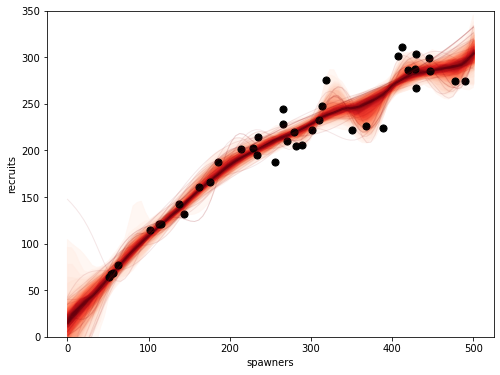

In [34]:
from pymc3.gp.util import plot_gp_dist
fig, ax = plt.subplots(figsize=(8,6))
plot_gp_dist(ax, gp_salmon_samples['salmon_pred'], X_pred)
salmon_data.plot.scatter(x='spawners', y='recruits', c='k', s=50, ax=ax)
ax.set_ylim(0, 350);

In [35]:
with gp_salmon_model:
    salmon_pred_noise = recruit_gp.conditional("salmon_pred_noise", X_pred.reshape(-1,1), pred_noise=True)
    gp_salmon_samples = pm.sample_posterior_predictive(gp_trace, var_names=["salmon_pred_noise"], samples=500, random_seed=42)

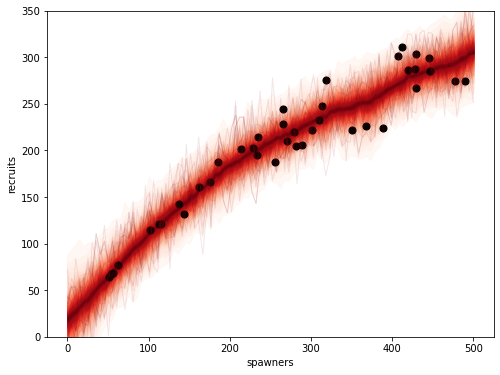

In [36]:
from pymc3.gp.util import plot_gp_dist
fig, ax = plt.subplots(figsize=(8,6))
plot_gp_dist(ax, gp_salmon_samples['salmon_pred_noise'], X_pred)
salmon_data.plot.scatter(x='spawners', y='recruits', c='k', s=50, ax=ax)
ax.set_ylim(0, 350);